In [1]:
%load_ext autoreload
%autoreload complete
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from protest_impact.util import cache

In [2]:
from protest_impact.data.protests import get_climate_protests, get_climate_queries

protests = get_climate_protests(groups=["fff"])
queries = get_climate_queries()
prev_size_cols = ["size_week_-1", "size_week_-2", "size_week_-3", "size_week_-4"]
exog_cols = ["sub_event_type", "assoc_actor_1", "admin1", "weekday"]
protests[exog_cols] = protests[exog_cols].astype("category")
exog_cols = []  # exog_cols + prev_size_cols

## Different causal methods

### Observational

In [3]:
from protest_impact.instrumental_variables import get_discourse


def _get_observational(protests, query):
    p = pd.DataFrame()
    for day in np.arange(-14, 14):
        p[f"impact_day_{day}"] = get_discourse(protests, queries[query][0], day)
    return p


def get_observational(protests, query):
    return pd.concat([protests, _get_observational(protests, query)], axis=1)

### Instrumental variables

#### Checks

Rule of thumb (F-statistic > 10):

In [10]:
from linearmodels.iv import IV2SLS, IVGMM, IVGMMCUE, IVLIML

from protest_impact.instrumental_variables import get_instruments

p = protests[protests["size"] > 0]
X = get_instruments(p)[["stringency_index", "pres"]]
X = sm.add_constant(X)
res_first = IV2SLS(np.log10(p["size"]), X, None, None).fit()
res_first.f_statistic

Inputs contain missing values. Dropping rows with missing observations.


Model F-statistic
H0: All parameters ex. constant are zero
Statistic: 17.6641
P-value: 0.0001
Distributed: chi2(2)
WaldTestStatistic, id: 0x2a67dadd0

In [11]:
res_first.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                   size   R-squared:                      0.0863
Estimator:                        OLS   Adj. R-squared:                 0.0772
No. Observations:                 204   F-statistic:                    17.664
Date:                Wed, May 31 2023   P-value (F-stat)                0.0001
Time:                        16:13:21   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                24.244     7.0817     3.4234     0.0006      10.364      38.124
stringency_index    -0.7641     0.2061    -3.7081     0.0002     -1.1679     -0.3602
pres                -0.0211     0.0069    -3.0452     0.0023     -0.0346     -0.0075
====================================================================================
"""

Endogeneity:

In [20]:
instr = get_instruments(p)[["stringency_index", "pres"]]
endog = np.log10(p["size"])
exog = p[exog_cols]
exog = sm.add_constant(exog)
dep = get_discourse(p, queries["climate_and_protest"][0], 0)
res = IV2SLS(dep, exog, endog, instr).fit()
res.wooldridge_regression

Inputs contain missing values. Dropping rows with missing observations.


Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.0578
P-value: 0.8101
Distributed: chi2(1)
WaldTestStatistic, id: 0x2a6a07280

In [21]:
res.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 0.0577
P-value: 0.8102
Distributed: chi2(1)
WaldTestStatistic, id: 0x2a6a06710

Overidentification:

In [22]:
res.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 0.1302
P-value: 0.7183
Distributed: chi2(1)
WaldTestStatistic, id: 0x2a6a06ef0

#### Calculate

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, QuantileRegressor, RidgeCV

from protest_impact.instrumental_variables.auto import AutoRandomForestRegressor

In [28]:
import time

from protest_impact.instrumental_variables import get_instruments


def get_instrumental(protests, query):
    t = time.time()
    p = protests.copy()
    instruments = get_instruments(p)[["pres", "stringency_index"]]
    if len(exog_cols) > 0:
        exog = pd.get_dummies(p[exog_cols], drop_first=True)
        X = pd.concat([exog, instruments], axis=1)
    else:
        X = instruments
    y = p["size"]
    # model = AutoRandomForestRegressor()
    model = RidgeCV()
    print("fitting model", time.time() - t)
    model.fit(X, y)
    print("done fitting", time.time() - t)
    p = p.drop(columns=["size"])
    p["size"] = model.predict(X)
    p = pd.concat([p, _get_observational(p, query)], axis=1)
    print("done predicting", time.time() - t)
    return p

## Impact of size

In [29]:
import pandas as pd
from sklearn.linear_model import LinearRegression, QuantileRegressor


def calc_size_factor(protests):
    """
    protests: must contain both size and impact for each day (`impact_day_0`, ...),
        size or impact may or may not be adjusted by some causal method
    """
    p = protests.copy()
    p = p[p["size"] > 0]
    X = p[exog_cols]
    if len(exog_cols) > 0:
        X = pd.get_dummies(X, drop_first=True)
    X["size"] = np.log10(p["size"] + 1)
    assert X.columns[-1] == "size"
    size_params = dict()
    for day in np.arange(-14, 14):
        y = p[f"impact_day_{day}"]
        model = QuantileRegressor(quantile=0.5, alpha=0, solver="highs")
        model.fit(X, y)
        size_params[day] = model.coef_[-1]
    return size_params


def calc_size_factor_2sls(protests):
    p = protests.copy()
    p = p[p["size"] > 0]
    exog = p[exog_cols]
    exog = sm.add_constant(exog)
    endog = np.log10(p["size"])
    instr = get_instruments(p)[["stringency_index", "pres"]]
    size_params = dict()
    for day in np.arange(-14, 14):
        print(day)
        # ols
        X = instr
        X = sm.add_constant(X)
        res_first = IV2SLS(endog, X, None, None).fit()
        # iv
        dep = get_discourse(p, queries["climate_and_protest"][0], day)
        res = IV2SLS(dep, exog, endog, instr).fit()
        if res_first.f_statistic.stat < 11:
            print(f"\tweak instruments: {res_first.f_statistic.stat}")
        elif res.wooldridge_regression.pval > 0.05:
            print(
                f"\tendogenous variables are exogenous: {res.wooldridge_regression.pval}"
            )
        elif res.wooldridge_score.pval > 0.05:
            print(f"\tendogenous variables are exogenous: {res.wooldridge_score.pval}")
        elif res.wooldridge_overid.pval < 0.3:
            print(f"\tmodel is overidentified: {res.wooldridge_overid.pval}")
        elif res.pvalues["size"] > 0.05:
            print(f"\tsize param is not significant: {res.pvalues['size']}")
        else:
            size_params[day] = (
                res.params["size"],
                res.conf_int().loc["size", "lower"],
                res.conf_int().loc["size", "upper"],
            )
    return size_params

## Comparison

In [30]:
observational_protests = get_observational(protests, "climate_and_protest")
observational_factors = calc_size_factor(observational_protests)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
instrumental_protests = get_instrumental(protests, "climate_and_protest")
instrumental_factors = calc_size_factor(instrumental_protests)

In [ ]:
instrumental_factors_2sls = calc_size_factor_2sls(protests)

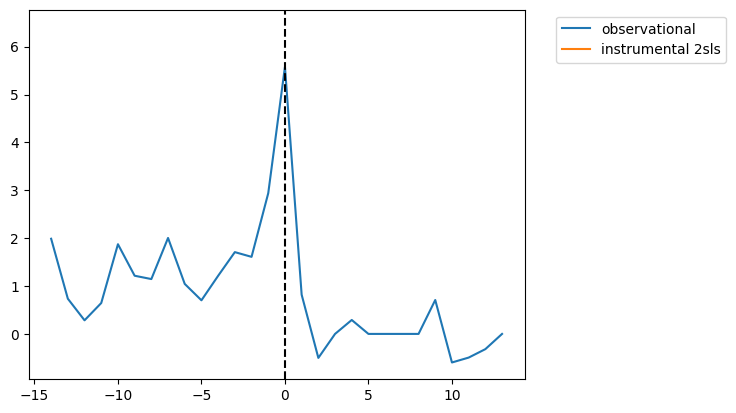

In [23]:
import matplotlib.pyplot as plt

plt.plot(
    observational_factors.keys(), observational_factors.values(), label="observational"
)
plt.plot(
    instrumental_factors.keys(), instrumental_factors.values(), label="instrumental"
)
plt.plot(
    instrumental_factors_2sls.keys(),
    [a[0] for a in instrumental_factors_2sls.values()],
    label="instrumental 2sls",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.axvline(0, color="black", linestyle="--")